### Load Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import os
import re
import random

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

import openai
import time

### Load cleaned data

In [2]:
# load text data, feature data, and labels from file
train_text = np.loadtxt(r"...\Capstone3-MedicalSentimentAnalysis\Data\Processed_data\train_text_cleaned.csv", delimiter=",", dtype=str)
train_features = pd.read_csv(r"...\Capstone3-MedicalSentimentAnalysis\Data\Processed_data\train_features.csv", index_col=0)
train_labels = pd.read_csv(r"...\Git\Capstone3-MedicalSentimentAnalysis\Data\Processed_data\train_labels.csv", index_col=0)

In [3]:
# check data
display(train_text)

array(['catheterization laboratory event hospital outcome direct angioplasty acute myocardial infarction ass safety direct infarct angioplasty without antecedent thrombolytic therapy catheterization laboratory hospital event assess consecutively treated patient infarction involve leave anterior descend n patient right n circumflex n coronary artery group patient similar age leave anterior descend coronary artery year right coronary artery year circumflex coronary artery year patient multivessel disease leave anterior descend coronary artery right coronary artery circumflex coronary artery patient initial grade antegrade flow leave anterior descend coronary artery right coronary artery circumflex coronary artery cardiogenic shock present eight patient infarction leave anterior descend coronary artery four infarction right coronary artery four infarction circumflex coronary artery major catheterization laboratory event cardioversion cardiopulmonary resuscitation dopamine intra aortic bal

In [4]:
# check shape
np.shape(train_text)

(14438,)

In [5]:
train_features.head()

,char_count,word_count,capital_word_count,quoted_word_count,sent_count,unique_word_count,stopword_count,avg_wordlength,avg_sentlength,unique_vs_words,stopwords_vs_words,noun_count,adj_count,verb_count,adv_count
0,1687,234,0,0,5,108,51,7.209402,46.800000,0.461538,0.217949,88,47,19,9
1,963,147,2,0,9,102,47,6.551020,16.333333,0.693878,0.319728,43,20,17,6
2,1032,142,0,0,11,85,47,7.267606,12.909091,0.598592,0.330986,35,24,19,1
3,871,131,0,0,8,93,52,6.648855,16.375000,0.709924,0.396947,38,23,10,5
4,2012,275,9,0,9,157,84,7.316364,30.555556,0.570909,0.305455,98,45,31,11


In [6]:
train_labels.head()

,label
0,3
1,4
2,1
3,4
4,3


### Tf-idf Vectorizer Parameter Testing

Now I want to apply a tf-idf vectorizer to the text data. I have found that the maximum size that my laptop can handle is approximately 10000 features. However, I do not know if the maximum size is best for classification, therefore, I will parameter test the "max_features" parameter.

To do this, I am going to train simple random forest, xgboost, and catboost classifiers with a variety of max_feature tf-idf values. Furthermore, I will train and test with two different datasets, one with the added features and one without. Lastly, for the sake of training time, I will allocate 70% of the data to the testing set. 

In [3]:
# function to calculate confusion matrix, precision, recall, accuracy, and f1-score for all models
def evaluation(y, y_hat, title = 'Confusion Matrix'):
    cm = confusion_matrix(y, y_hat)
    precision = precision_score(y, y_hat, average='macro')
    recall = recall_score(y, y_hat, average='macro')
    accuracy = accuracy_score(y,y_hat)
    f1 = f1_score(y, y_hat, average='macro')
    print('Recall: ', recall)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('F1: ', f1)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws=    {'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show();     

In [4]:
# convert model prediction probabilities into integer labels
def assign_labels(y_pred):
    y_pred_labels = []
    for obs in range(len(y_pred)):
        index_max = np.argmax(y_pred[obs,:])
        y_pred_labels.append(index_max)
        
    return np.array(y_pred_labels)

In [9]:
# loop through tf-idf features and calculate baseline XGBoost and Random Forest models to find optimal # of tf-idf features
num_features = [200, 500, 1000, 2500, 5000, 7500, 10000]
model = []
acc = []
f1 = []
for n_features in num_features:
    #tf-idf vectorizer
    vectorizer = TfidfVectorizer(max_features=n_features)
    train_tf_idf_features = vectorizer.fit_transform(train_text).toarray()
    train_tf_idf = pd.DataFrame(train_tf_idf_features)
    
    #loop through both dataset arrangements
    for sets in range(2):
        if sets == 0:
            X_train, X_test, y_train, y_test = train_test_split(train_tf_idf, train_labels, test_size=0.7, random_state=42)
            
            # Random Forest Classifier
            rfc = RandomForestClassifier(random_state=42)
            rfc.fit(X_train, y_train)
            y_pred = rfc.predict_proba(X_test)
            y_pred = assign_labels(y_pred)
            model.append("Random Forest with " + str(n_features) + " tf-idf features")
            acc.append(accuracy_score(y_test, y_pred))
            f1.append(f1_score(y_test, y_pred, average='macro'))
            print("Random Forest with " + str(n_features) + " tf-idf features")
            
            # XGBoost
            xgb_model = XGBClassifier(random_state=42)
            xgb_model.fit(X_train, y_train)
            y_pred = xgb_model.predict_proba(X_test)
            y_pred = assign_labels(y_pred)
            model.append("XGBoost with " + str(n_features) + " tf-idf features")
            acc.append(accuracy_score(y_test, y_pred))
            f1.append(f1_score(y_test, y_pred, average='macro'))
            print("XGBoost with " + str(n_features) + " tf-idf features")

        else:
            X = pd.merge(train_tf_idf,train_features,left_index=True, right_index=True)
            X_train, X_test, y_train, y_test = train_test_split(X, train_labels, test_size=0.6, random_state=42)
            
            # Random Forest Classifier
            rfc = RandomForestClassifier(random_state=42)
            rfc.fit(X_train, y_train)
            y_pred = rfc.predict_proba(X_test)
            y_pred = assign_labels(y_pred)
            model.append("Random Forest w/ added features and " + str(n_features) + " tf-idf features")
            acc.append(accuracy_score(y_test, y_pred))
            f1.append(f1_score(y_test, y_pred, average='macro'))
            print("Random Forest w/ added features and " + str(n_features) + " tf-idf features")
            
            # XGBoost
            xgb_model = XGBClassifier(random_state=42)
            xgb_model.fit(X_train, y_train)
            y_pred = xgb_model.predict_proba(X_test)
            y_pred = assign_labels(y_pred)
            model.append("XGBoost w/ added features and " + str(n_features) + " tf-idf features")
            acc.append(accuracy_score(y_test, y_pred))
            f1.append(f1_score(y_test, y_pred, average='macro'))
            print("XGBoost w/ added features and " + str(n_features) + " tf-idf features")

Random Forest with 200 tf-idf features
XGBoost with 200 tf-idf features
Random Forest w/ added features and 200 tf-idf features
XGBoost w/ added features and 200 tf-idf features
Random Forest with 500 tf-idf features
XGBoost with 500 tf-idf features
Random Forest w/ added features and 500 tf-idf features
XGBoost w/ added features and 500 tf-idf features
Random Forest with 1000 tf-idf features
XGBoost with 1000 tf-idf features
Random Forest w/ added features and 1000 tf-idf features
XGBoost w/ added features and 1000 tf-idf features
Random Forest with 2500 tf-idf features
XGBoost with 2500 tf-idf features
Random Forest w/ added features and 2500 tf-idf features
XGBoost w/ added features and 2500 tf-idf features
Random Forest with 5000 tf-idf features
XGBoost with 5000 tf-idf features
Random Forest w/ added features and 5000 tf-idf features
XGBoost w/ added features and 5000 tf-idf features
Random Forest with 7500 tf-idf features
XGBoost with 7500 tf-idf features
Random Forest w/ added f

In [11]:
# collect model metrics into lists for plotting and displaying results
acc_np = np.array(acc)
f1_np = np.array(f1)
random_forest_wo_features_acc = list(acc_np[[0, 4, 8, 12, 16, 20, 24]])
xgboost_wo_features_acc = list(acc_np[[1, 5, 9, 13, 17, 21, 25]])
random_forest_with_features_acc = list(acc_np[[2, 6, 10, 14, 18, 22, 26]])
xgboost_with_features_acc = list(acc_np[[3, 7, 11, 15, 19, 23, 27]])

random_forest_wo_features_f1 = list(f1_np[[0, 4, 8, 12, 16, 20, 24]])
xgboost_wo_features_f1 = list(f1_np[[1, 5, 9, 13, 17, 21, 25]])
random_forest_with_features_f1 = list(f1_np[[2, 6, 10, 14, 18, 22, 26]])
xgboost_with_features_f1 = list(f1_np[[3, 7, 11, 15, 19, 23, 27]])

In [12]:
# Accuracy results
temp_array = np.transpose(np.array([num_features, random_forest_wo_features_acc, xgboost_wo_features_acc, random_forest_with_features_acc, xgboost_with_features_acc]))
acc_df = pd.DataFrame(temp_array, columns = ['num_features', 'random_forest_wo_features', 'xgboost_wo_features', 'random_forest_with_features', 'xgboost_with_features'])
acc_df = acc_df.set_index('num_features')
acc_df.head()

,random_forest_wo_features,xgboost_wo_features,random_forest_with_features,xgboost_with_features
num_features,,,,
200.0,0.493025,0.476007,0.475355,0.467736
500.0,0.522014,0.504898,0.501097,0.503982
1000.0,0.536559,0.529831,0.518065,0.520259
2500.0,0.539230,0.541803,0.522221,0.528916
5000.0,0.537054,0.542001,0.517142,0.532495


In [13]:
# F1-score results
temp_array = np.transpose(np.array([num_features, random_forest_wo_features_f1, xgboost_wo_features_f1, random_forest_with_features_f1, xgboost_with_features_f1]))
f1_df = pd.DataFrame(temp_array, columns = ['num_features', 'random_forest_wo_features', 'xgboost_wo_features', 'random_forest_with_features', 'xgboost_with_features'])
f1_df = f1_df.set_index('num_features')
f1_df.head()

,random_forest_wo_features,xgboost_wo_features,random_forest_with_features,xgboost_with_features
num_features,,,,
200.0,0.400221,0.417710,0.386720,0.408834
500.0,0.458858,0.468288,0.435891,0.467271
1000.0,0.490375,0.502757,0.471693,0.493521
2500.0,0.494676,0.518610,0.477519,0.506314
5000.0,0.486142,0.519596,0.459549,0.509308


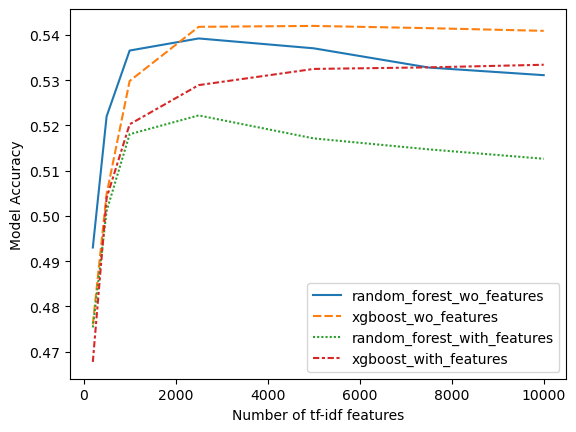

In [14]:
# Accuracy plot
sns.lineplot(data=acc_df)
plt.xlabel('Number of tf-idf features')
plt.ylabel('Model Accuracy')
plt.show()

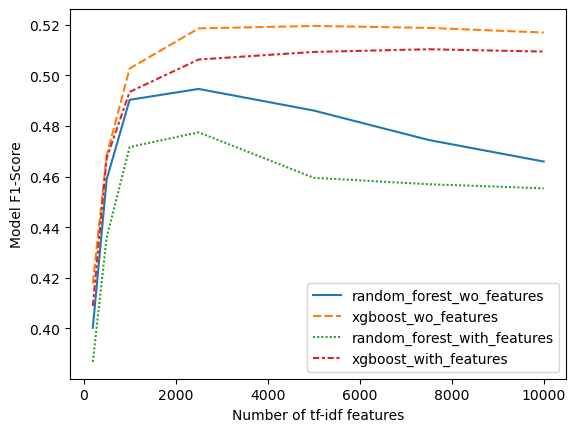

In [15]:
# F1-score plot
sns.lineplot(data=f1_df)
plt.xlabel('Number of tf-idf features')
plt.ylabel('Model F1-Score')
plt.show()

From these plots, we can conclude that 2500 tf-idf features is going to be optimal for both the accuracy and F1-score. Also, we can see that the model that performed the best (both in accuracy and F1-score) is the XGBoost model without features. However, the XGBoost model with the added features was only slightly behind in F1-score. We will further investigate the model performance of the added features when we add additional models and perform parameter testing.

### Modeling

First, I want to train baseline models using a larger majority of the data for training. Also, I am including a CatBoost classifier to compare its results to random forest classifiers and XGBoost. Then, I will parameter test the best performers to see how good our results can get. 

In [5]:
#tf-idf vectorizer
vectorizer = TfidfVectorizer(max_features=2500)
train_tf_idf_features = vectorizer.fit_transform(train_text).toarray()
train_tf_idf = pd.DataFrame(train_tf_idf_features)

Random Forest
Recall:  0.45554232878321627
Accuracy:  0.48545706371191133
Precision:  0.47331920618514056
F1:  0.461741519605391


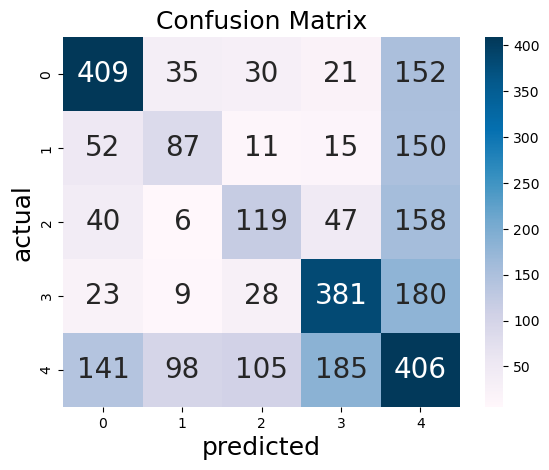

XGBoost
Recall:  0.5013185777002251
Accuracy:  0.5273545706371191
Precision:  0.5228216168390379
F1:  0.5103137581827232


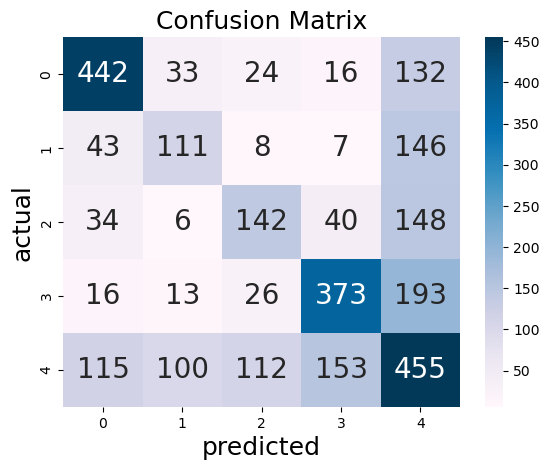

CatBoost
Recall:  0.5509222637876231
Accuracy:  0.5841412742382271
Precision:  0.5925928349036249
F1:  0.5663662707245223


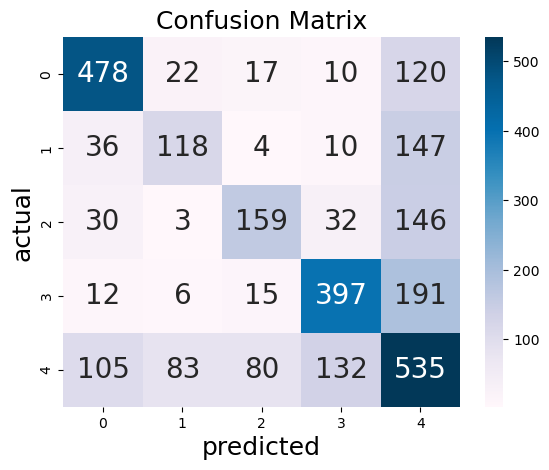

Random Forest w/ added features
Recall:  0.4505740782199907
Accuracy:  0.4851108033240997
Precision:  0.47554389727159707
F1:  0.4588732836466347


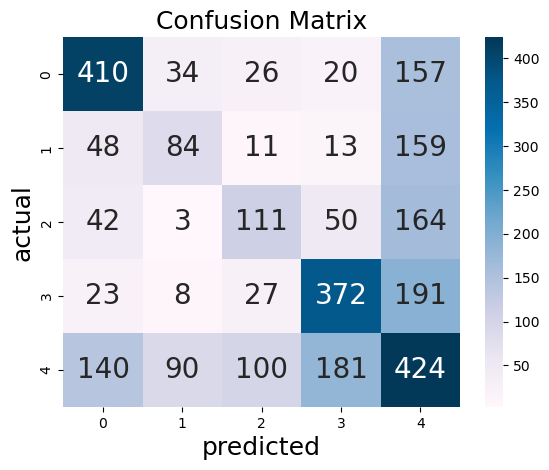

XGBoost w/ added features
Recall:  0.4947089283432904
Accuracy:  0.5249307479224377
Precision:  0.5206624230400381
F1:  0.5050477390317404


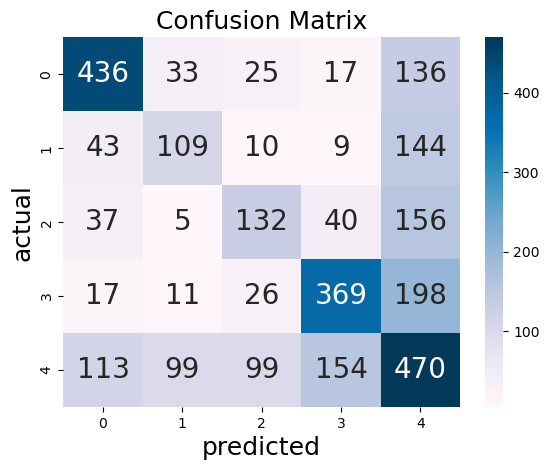

CatBoost w/ added features
Recall:  0.5551687455714304
Accuracy:  0.590027700831025
Precision:  0.5983900489392944
F1:  0.5710097444424038


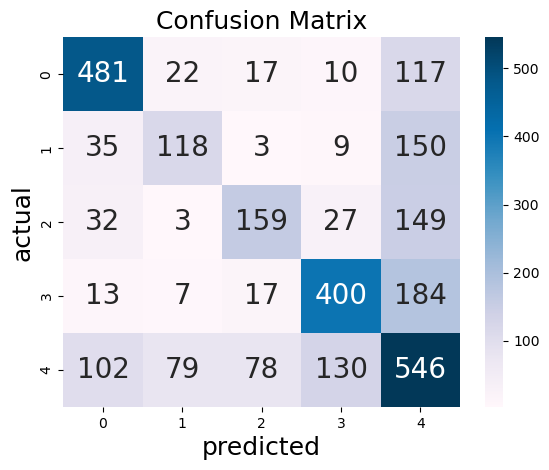

In [17]:
# generate baseline random forest, XGBoost, and CatBoost models
model_2 = []
acc_2 = []
f1_2 = []
#loop through both dataset arrangements
for sets in range(2):
    if sets == 0:
        X_train, X_test, y_train, y_test = train_test_split(train_tf_idf, train_labels, test_size=0.2, random_state=42)

        # Random Forest Classifier
        rfc = RandomForestClassifier(random_state=42)
        rfc.fit(X_train, y_train)
        y_pred = rfc.predict_proba(X_test)
        y_pred = assign_labels(y_pred)
        model_2.append("Random Forest")
        acc_2.append(accuracy_score(y_test, y_pred))
        f1_2.append(f1_score(y_test, y_pred, average='macro'))
        print("Random Forest")
        evaluation(y_test, y_pred)

        # XGBoost
        xgb_model = XGBClassifier(random_state=42)
        xgb_model.fit(X_train, y_train)
        y_pred = xgb_model.predict_proba(X_test)
        y_pred = assign_labels(y_pred)
        model_2.append("XGBoost")
        acc_2.append(accuracy_score(y_test, y_pred))
        f1_2.append(f1_score(y_test, y_pred, average='macro'))
        print("XGBoost")
        evaluation(y_test, y_pred)

        # CatBoost
        cbc = CatBoostClassifier(random_state=42)
        cbc.fit(X_train, y_train, silent=True)
        y_pred = cbc.predict_proba(X_test)
        y_pred = assign_labels(y_pred)
        model_2.append("CatBoost")
        acc_2.append(accuracy_score(y_test, y_pred))
        f1_2.append(f1_score(y_test, y_pred, average='macro'))
        print("CatBoost")
        evaluation(y_test, y_pred)

    else:
        X = pd.merge(train_tf_idf,train_features,left_index=True, right_index=True)
        X_train, X_test, y_train, y_test = train_test_split(X, train_labels, test_size=0.2, random_state=42)

        # Random Forest Classifier
        rfc = RandomForestClassifier(random_state=42)
        rfc.fit(X_train, y_train)
        y_pred = rfc.predict_proba(X_test)
        y_pred = assign_labels(y_pred)
        model_2.append("Random Forest w/ added features")
        acc_2.append(accuracy_score(y_test, y_pred))
        f1_2.append(f1_score(y_test, y_pred, average='macro'))
        print("Random Forest w/ added features")
        evaluation(y_test, y_pred)

        # XGBoost
        xgb_model = XGBClassifier(random_state=42)
        xgb_model.fit(X_train, y_train)
        y_pred = xgb_model.predict_proba(X_test)
        y_pred = assign_labels(y_pred)
        model_2.append("XGBoost w/ added features")
        acc_2.append(accuracy_score(y_test, y_pred))
        f1_2.append(f1_score(y_test, y_pred, average='macro'))
        print("XGBoost w/ added features")
        evaluation(y_test, y_pred)

        # CatBoost
        cbc = CatBoostClassifier(random_state=42)
        cbc.fit(X_train, y_train, silent=True)
        y_pred = cbc.predict_proba(X_test)
        y_pred = assign_labels(y_pred)
        model_2.append("CatBoost w/ added features")
        acc_2.append(accuracy_score(y_test, y_pred))
        f1_2.append(f1_score(y_test, y_pred, average='macro'))
        print("CatBoost w/ added features")
        evaluation(y_test, y_pred)

In [18]:
# Baseline model results
results_df = pd.DataFrame(np.transpose(np.array([model_2, acc_2, f1_2])), columns=['model', 'accuracy', 'f1-score'])
results_df

,model,accuracy,f1-score
0,Random Forest,0.48545706371191133,0.461741519605391
1,XGBoost,0.5273545706371191,0.5103137581827232
2,CatBoost,0.5841412742382271,0.5663662707245223
3,Random Forest w/ added features,0.4851108033240997,0.4588732836466347
4,XGBoost w/ added features,0.5249307479224377,0.5050477390317404
5,CatBoost w/ added features,0.590027700831025,0.5710097444424038


In [6]:
# re-run best model
X = pd.merge(train_tf_idf,train_features,left_index=True, right_index=True)
X_train, X_test, y_train, y_test = train_test_split(X, train_labels, test_size=0.2, random_state=42)

Recall:  0.5551687455714304
Accuracy:  0.590027700831025
Precision:  0.5983900489392944
F1:  0.5710097444424038


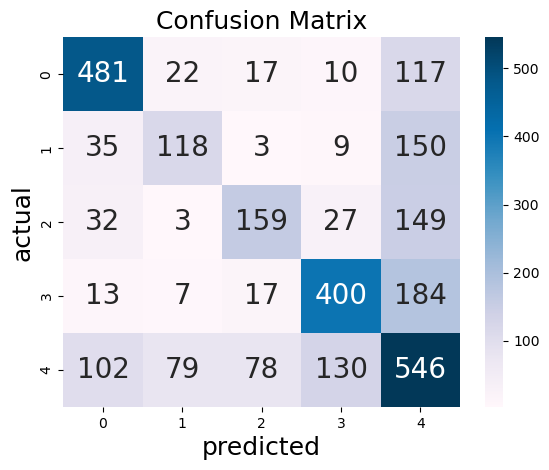

In [7]:
cbc = CatBoostClassifier(random_state=42)
cbc.fit(X_train, y_train, silent=True)
y_pred = cbc.predict_proba(X_test)
y_pred = assign_labels(y_pred)
evaluation(y_test, y_pred)

In [21]:
# added feature importances of best model
cbc_feature_importance = pd.DataFrame(np.transpose(np.array([train_features.columns, cbc.feature_importances_[2500:2515]])), columns=["feature", "importance"])
cbc_feature_importance.sort_values('importance', ascending=False)

,feature,importance
9,unique_vs_words,0.333047
10,stopwords_vs_words,0.327831
11,noun_count,0.311376
5,unique_word_count,0.295317
1,word_count,0.291346
8,avg_sentlength,0.261559
2,capital_word_count,0.255978
7,avg_wordlength,0.207939
12,adj_count,0.176331
0,char_count,0.099779


In [118]:
# find misclassified indexes to use later in chatbot portion
miscalc_idx = []
y_test_np = np.array(y_test['label'])
for obs in range(len(y_pred)):
    if y_test_np[obs] != y_pred[obs]:
        miscalc_idx.append(obs)
        
print("Number of misclassifications: " + str(len(miscalc_idx)))

Number of misclassifications: 1184


### Parameter Test Random Forest Classifier

Now, let's parameter test the Random Forest classifier to see if the results of the base model can be improved. It is difficult to parameter test CatBoost here because of the large number of columns and the amount of time it takes to parameter test. The results of the base model with the added features are slightly better, so we will use that combination for the testing.

In [7]:
# merge text data and feature data
X = pd.merge(train_tf_idf,train_features,left_index=True, right_index=True)
X_train, X_test, y_train, y_test = train_test_split(X, train_labels, test_size=0.2, random_state=42)

In [10]:
# create grid search and fit model
params = {'n_estimators':[50, 100, 200, 300], 'max_depth':[3,7,20], 'min_samples_split':[2,4,10]}
rfc = RandomForestClassifier(random_state=42)
rfc_cv = GridSearchCV(rfc, params, scoring='accuracy', cv=3)
rfc_cv.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [3, 7, 20],
                         'min_samples_split': [2, 4, 10],
                         'n_estimators': [50, 100, 200, 300]},
             scoring='accuracy')

In [11]:
# print best parameters
print("Best Parameters: " + str(rfc_cv.best_params_))

Best Parameters: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 200}


Recall:  0.4142170686568794
Accuracy:  0.5200831024930748
Precision:  0.5003649634829964
F1:  0.3980757038491559


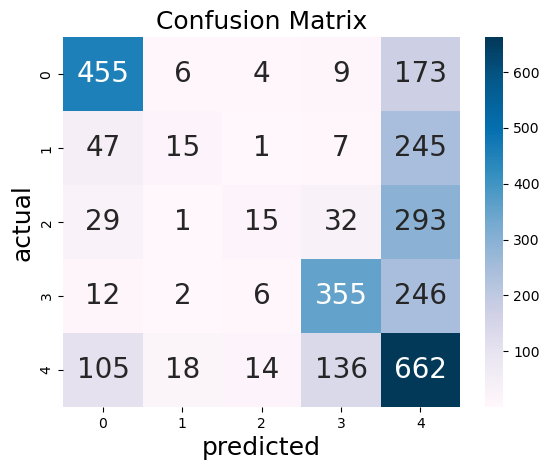

In [12]:
# re-evaluate random forest model with best parameters
rfc = RandomForestClassifier(max_depth=20, min_samples_split=10, n_estimators=200, random_state=42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict_proba(X_test)
y_pred = assign_labels(y_pred)
evaluation(y_test, y_pred)

We can see that the parameter testing did improve the accuracy of the random forest model. However, the f1-score did suffer a bit, and this model could be considered worse than the base model in some circumstances. But, we did optimize for accuracy performance, therefore, this shows as a proof of concept that the models can be improved slightly through parameter testing. With more time and computing power, parameter testing the CatBoost model may be beneficial to develop a superior model. 

### Comparing with ChatGPT

Next, I want to compare our results with the performance of ChatGPT. For this testing, I am going to do a few different things: (1) test an OpenAI chatbot on a random subset of 3000 preprocessed observations, (2) test a chatbot on only the misclassified preprocessed data from the CatBoost model, and (3) test a chatbot on a random subset of raw data. All models will be processed using OpenAI's GPT-3 "text-curie-001" engine. This model according to the website is "very capable, faster and lower cost than Davinci". The price point is important here because the API is not free to use with this many requests and GPT-3 requests are not as strictly throttled as more high-end models. The results from this analysis will give us a valuable baseline comparison between traditional machine learning techniques and AI chatbots. 

#### Preprocessed Text

##### (a) Curie engine

In [67]:
# take a random sample of "n" length
n_samples = 3000
sample_idx = random.sample(range(len(train_text)), n_samples)

In [98]:
# loop through records and request API responses
openai.api_key = "..."
chatbot_predict = []
model_engine='text-curie-001'
for record in sample_idx: 
    prompt = "Is the diagnosis a digestive system diseases, cardiovascular diseases, neoplasms, nervous system diseases, \
    or general pathological conditions if the patient has the following conditions: '" + str(train_text[record]) + "'"
    
    completion = openai.Completion.create(
        engine = model_engine,
        prompt = prompt,
        max_tokens=1024,
        n=1,
        stop=None,
        temperature=0.5)

    response = completion.choices[0].text
    chatbot_predict.append(response)

In [99]:
# remove "\n" characters from text and split into list
temp = chatbot_predict
temp = str(temp).lower()
temp = temp.replace('\\n\\n','')
temp = temp.split(',')

Labels diagnosis description:

0: neoplasms

1: digestive system diseases

2: nervous system diseases

3: cardiovascular diseases

4: general pathological conditions

In [101]:
# convert API responses into categorical-numerical responses
chatbot_predict_numerical = np.empty(n_samples)
for sample in range(n_samples):
    substring1 = "digestive"
    substring3 = "cardiovascular"
    substring0 = "neoplasm"
    substring2 = "nervous"
    substring4 = "general pathological"

    if substring0 in temp[sample]:
        chatbot_predict_numerical[sample] = 0
    elif substring1 in temp[sample]:
        chatbot_predict_numerical[sample] = 1
    elif substring2 in temp[sample]:
        chatbot_predict_numerical[sample] = 2
    elif substring3 in temp[sample]:
        chatbot_predict_numerical[sample] = 3
    elif substring4 in temp[sample]:
        chatbot_predict_numerical[sample] = 4
    else: # the case where the API did not predict any of the options, replace with NaN
        chatbot_predict_numerical[sample] = np.nan
        
chatbot_predict_numerical

array([ 4., nan,  4., ...,  4.,  4.,  4.])

In [102]:
# count NaN values
np.count_nonzero(np.isnan(chatbot_predict_numerical))

765

In [103]:
# remove NaN observations from the samples and labels
nan_idx = np.argwhere(np.isnan(chatbot_predict_numerical))
chatbot_predict_numerical_nonan = np.delete(chatbot_predict_numerical, obj=nan_idx, axis=0)
train_labels_nonan = np.delete(np.array(train_labels.iloc[sample_idx]), obj=nan_idx, axis=0)

Recall:  0.2048111440165114
Accuracy:  0.3208053691275168
Precision:  0.22891376586228956
F1:  0.13361097991099738


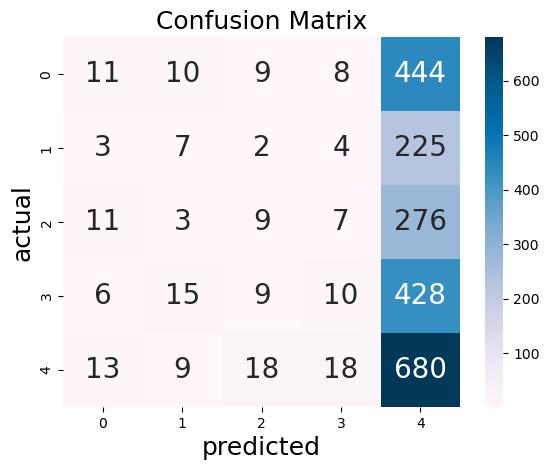

In [104]:
# evaluate performance metrics
evaluation(train_labels_nonan, chatbot_predict_numerical_nonan)

In [116]:
# calculate actual accuracy (including NaN responses as misclassifications)
print("Actual Accuracy: 0.2390")

Actual Accuracy: 0.2390


##### (b) Devinci engine

In [117]:
# loop through records and request API responses
openai.api_key = "..."
chatbot_predict_davinci = []
model_engine = "text-davinci-003"
for record in sample_idx: 
    prompt = "Is the diagnosis a digestive system diseases, cardiovascular diseases, neoplasms, nervous system diseases, \
    or general pathological conditions if the patient has the following conditions: '" + str(train_text[record]) + "'"
    
    completion = openai.Completion.create(
        engine = model_engine,
        prompt = prompt,
        max_tokens=1024,
        n=1,
        stop=None,
        temperature=0.5)

    response = completion.choices[0].text
    chatbot_predict_davinci.append(response)
    #time.sleep(1)

In [115]:
# remove "\n" characters from text and split into list
temp = chatbot_predict_davinci
temp = str(temp).lower()
temp = temp.replace('\\n\\n','')
temp = temp.split(',')

NameError: name 'chatbot_predict_davinci' is not defined

In [120]:
# convert API responses into categorical-numerical responses
chatbot_predict_davinci_numerical = np.empty(n_samples)
for sample in range(len(chatbot_predict_davinci)):
    substring1 = "digestive"
    substring3 = "cardiovascular"
    substring0 = "neoplasm"
    substring2 = "nervous"
    substring4 = "general pathological condition"

    if substring0 in temp[sample]:
        chatbot_predict_davinci_numerical[sample] = 0
    elif substring1 in temp[sample]:
        chatbot_predict_davinci_numerical[sample] = 1
    elif substring2 in temp[sample]:
        chatbot_predict_davinci_numerical[sample] = 2
    elif substring3 in temp[sample]:
        chatbot_predict_davinci_numerical[sample] = 3
    elif substring4 in temp[sample]:
        chatbot_predict_davinci_numerical[sample] = 4
    else: # the case where the API did not predict any of the options, replace with NaN
        chatbot_predict_davinci_numerical[sample] = np.nan
        
chatbot_predict_davinci_numerical

array([1., 4., 0., ..., 4., 4., 4.])

In [121]:
# count NaN values
np.count_nonzero(np.isnan(chatbot_predict_davinci_numerical))

8

In [127]:
# remove NaN observations from the samples and labels
nan_idx = np.argwhere(np.isnan(chatbot_predict_davinci_numerical))
chatbot_predict_numerical_nonan = np.delete(chatbot_predict_davinci_numerical, obj=nan_idx, axis=0)
train_labels_nonan = np.delete(np.array(train_labels.iloc[sample_idx]), obj=nan_idx, axis=0)

Recall:  0.2269456212129247
Accuracy:  0.24598930481283424
Precision:  0.23130562884193112
F1:  0.22352105240850043


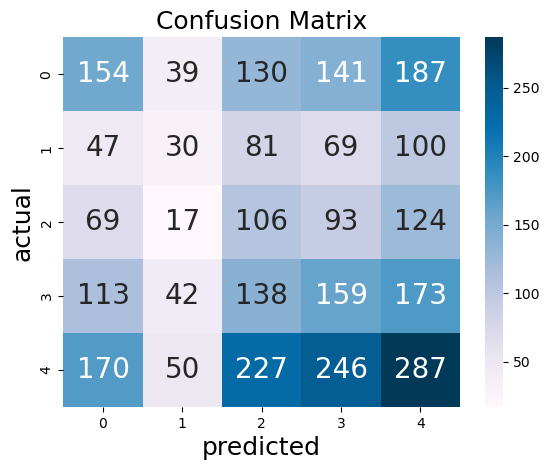

In [132]:
# evaluate performance metrics
evaluation(np.array(train_labels_nonan), chatbot_predict_numerical_nonan)

In [117]:
# calculate actual accuracy (including NaN responses as misclassifications)
print("Actual Accuracy: 0.2453")

Actual Accuracy: 0.2453


#### Raw Data

##### (a) Curie engine

In [39]:
# laod raw data
filepath = r"...\Capstone3-MedicalSentimentAnalysis\Data\Text_data\train.txt"

raw_data = pd.read_table(filepath, delimiter = '\t', names = ['idx', 'text'])
raw_data = {'text': raw_data['text']} # Soilik testua behar dugu
raw_data = pd.DataFrame(raw_data)

raw_data.head()

,text
0,Catheterization laboratory events and hospital...
1,Renal abscess in children. Three cases of rena...
2,Hyperplastic polyps seen at sigmoidoscopy are ...
3,Subclavian artery to innominate vein fistula a...
4,Effect of local inhibition of gamma-aminobutyr...


In [40]:
# create a list of the lines of text
with open(filepath) as f:
    contents = f.readlines()
    
#find all digits followed by tab
tab_digits = r"\d+\\t"
labels_raw = re.findall(tab_digits, str(contents))

digits = r"\d+"
labels = re.findall(digits, str(labels_raw))

# add new column to data
raw_data['label'] = labels

# convert to integer and zero-index labels
raw_data['label'] = raw_data['label'].astype(str).astype(int) - 1

print("Number of observations: " + str(len(raw_data)))
raw_data.head()

Number of observations: 14438


,text,label
0,Catheterization laboratory events and hospital...,3
1,Renal abscess in children. Three cases of rena...,4
2,Hyperplastic polyps seen at sigmoidoscopy are ...,1
3,Subclavian artery to innominate vein fistula a...,4
4,Effect of local inhibition of gamma-aminobutyr...,3


In [41]:
# take a random sample of "n" length
n_samples = 700
raw_data_sample = raw_data.sample(n=n_samples, random_state=42)
sample_idx2 = raw_data_sample.index
raw_data_label = raw_data_sample['label']

In [47]:
# loop through records and request API responses
openai.api_key = "..."
chatbot_predict_raw = []
model_engine='text-curie-001'
for record in sample_idx2: 
    prompt = "Is the diagnosis a digestive system diseases, cardiovascular diseases, neoplasms, nervous system diseases, \
    or general pathological conditions if the patient has the following conditions: '" + str(raw_data_sample.loc[record]['text']) + "'"
    
    completion = openai.Completion.create(
        engine = model_engine,
        prompt = prompt,
        max_tokens=1024,
        n=1,
        stop=None,
        temperature=0.5)

    response = completion.choices[0].text
    chatbot_predict_raw.append(response)

In [119]:
np.shape(chatbot_predict_raw)

(700,)

In [108]:
# remove "\n" characters from text and split into list
temp = chatbot_predict_raw
temp = str(temp).lower()
temp = temp.replace('\\n\\n','')
temp = temp.split(',')

In [109]:
# convert API responses into categorical-numerical responses
chatbot_predict_raw_numerical = np.empty(n_samples)
for sample in range(len(chatbot_predict_raw)):
    substring1 = "digestive"
    substring3 = "cardiovascular"
    substring0 = "neoplasm"
    substring2 = "nervous"
    substring4 = "general pathological"

    if substring0 in temp[sample]:
        chatbot_predict_raw_numerical[sample] = 0
    elif substring1 in temp[sample]:
        chatbot_predict_raw_numerical[sample] = 1
    elif substring2 in temp[sample]:
        chatbot_predict_raw_numerical[sample] = 2
    elif substring3 in temp[sample]:
        chatbot_predict_raw_numerical[sample] = 3
    elif substring4 in temp[sample]:
        chatbot_predict_raw_numerical[sample] = 4
    else: # the case where the API did not predict any of the options, replace with NaN
        chatbot_predict_raw_numerical[sample] = np.nan

In [110]:
# count NaN values
np.count_nonzero(np.isnan(chatbot_predict_raw_numerical))

258

In [111]:
# remove NaN observations from the samples and labels
nan_idx = np.argwhere(np.isnan(chatbot_predict_raw_numerical))
chatbot_predict_raw_numerical_nonan = np.delete(chatbot_predict_raw_numerical, obj=nan_idx, axis=0)
train_labels_raw_nonan = np.delete(np.array(raw_data_label), obj=nan_idx, axis=0)

Recall:  0.19420351776685893
Accuracy:  0.33031674208144796
Precision:  0.10921241050119332
F1:  0.10583601861797351


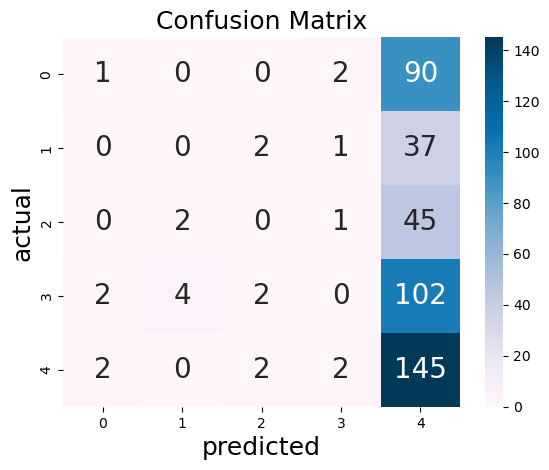

In [112]:
# evaluate performance metrics
evaluation(np.array(train_labels_raw_nonan), chatbot_predict_raw_numerical_nonan)

In [114]:
# calculate actual accuracy (including NaN responses as misclassifications)
print("Actual Accuracy: " + str(sum(np.array(train_labels_raw_nonan) == chatbot_predict_raw_numerical_nonan)/(len(chatbot_predict_raw_numerical_nonan) + np.count_nonzero(np.isnan(chatbot_predict_raw_numerical)))))

Actual Accuracy: 0.20857142857142857


##### (b) Devinci engine

In [123]:
# loop through records and request API responses
openai.api_key = "..."
chatbot_predict_raw_davinci = []
model_engine="text-davinci-003"
for record in sample_idx2: 
    prompt = "Is the diagnosis a digestive system diseases, cardiovascular diseases, neoplasms, nervous system diseases, \
    or general pathological conditions if the patient has the following conditions: '" + str(raw_data_sample.loc[record]['text']) + "'"
    
    completion = openai.Completion.create(
        engine = model_engine,
        prompt = prompt,
        max_tokens=1024,
        n=1,
        stop=None,
        temperature=0.5)

    response = completion.choices[0].text
    chatbot_predict_raw_davinci.append(response)

In [124]:
# remove "\n" characters from text and split into list
temp = chatbot_predict_raw_davinci
temp = str(temp).lower()
temp = temp.replace('\\n\\n','')
temp = temp.split(',')

In [125]:
# convert API responses into categorical-numerical responses
n_samples = 700
chatbot_predict_raw_davinci_numerical = np.empty(n_samples)
for sample in range(len(chatbot_predict_raw)):
    substring1 = "digestive"
    substring3 = "cardiovascular"
    substring0 = "neoplasm"
    substring2 = "nervous"
    substring4 = "general pathological"

    if substring0 in temp[sample]:
        chatbot_predict_raw_davinci_numerical[sample] = 0
    elif substring1 in temp[sample]:
        chatbot_predict_raw_davinci_numerical[sample] = 1
    elif substring2 in temp[sample]:
        chatbot_predict_raw_davinci_numerical[sample] = 2
    elif substring3 in temp[sample]:
        chatbot_predict_raw_davinci_numerical[sample] = 3
    elif substring4 in temp[sample]:
        chatbot_predict_raw_davinci_numerical[sample] = 4
    else: # the case where the API did not predict any of the options, replace with NaN
        chatbot_predict_raw_davinci_numerical[sample] = np.nan

In [126]:
# count NaN values
np.count_nonzero(np.isnan(chatbot_predict_raw_davinci_numerical))

6

In [127]:
# remove NaN observations from the samples and labels
nan_idx = np.argwhere(np.isnan(chatbot_predict_raw_davinci_numerical))
chatbot_predict_raw_davinci_numerical_nonan = np.delete(chatbot_predict_raw_davinci_numerical, obj=nan_idx, axis=0)
train_labels_raw_davinci_nonan = np.delete(np.array(raw_data_label), obj=nan_idx, axis=0)

Recall:  0.2793293763174782
Accuracy:  0.32132564841498557
Precision:  0.285910264605974
F1:  0.2758832112354424


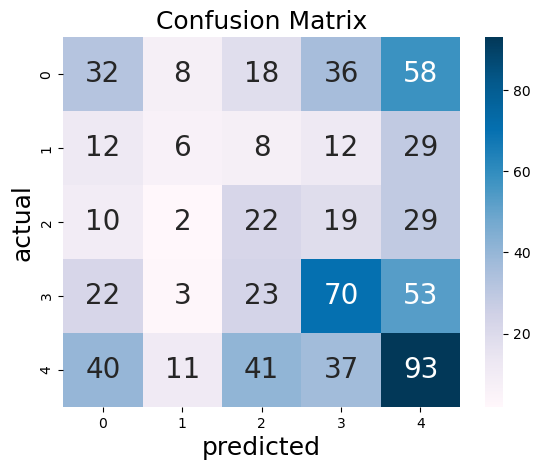

In [128]:
# evaluate performance metrics
evaluation(np.array(train_labels_raw_davinci_nonan), chatbot_predict_raw_davinci_numerical_nonan)

In [135]:
# calculate actual accuracy (including NaN responses as misclassifications)
print("Actual Accuracy: " + str(sum(np.array(train_labels_raw_davinci_nonan) == chatbot_predict_raw_davinci_numerical_nonan)/(len(chatbot_predict_raw_davinci_numerical_nonan) + np.count_nonzero(np.isnan(chatbot_predict_raw_davinci_numerical)))))

Actual Accuracy: 0.31857142857142856


#### Misclassified preprocessed data by CatBoost

##### (a) Curie engine

In [74]:
# take a random sample of "n" length
n_samples = 500
train_text_misc = train_text[miscalc_idx]
train_label_misc = train_labels.loc[miscalc_idx]['label']
sample_idx3 = random.sample(range(len(train_text_misc)), n_samples)

In [79]:
# loop through records and request API responses
openai.api_key = "..."
chatbot_predict_misc = []
model_engine='text-curie-001'
for record in sample_idx3: 
    prompt = "Is the diagnosis a digestive system diseases, cardiovascular diseases, neoplasms, nervous system diseases, \
    or general pathological conditions if the patient has the following conditions: '" + str(train_text_misc[record]) + "'"
    
    completion = openai.Completion.create(
        engine = model_engine,
        prompt = prompt,
        max_tokens=1024,
        n=1,
        stop=None,
        temperature=0.5)

    response = completion.choices[0].text
    chatbot_predict_misc.append(response)

In [80]:
# remove "\n" characters from text and split into list
temp = chatbot_predict_misc
temp = str(temp).lower()
temp = temp.replace('\\n\\n','')
temp = temp.split(',')

In [81]:
# convert API responses into categorical-numerical responses
chatbot_predict_misc_numerical = np.empty(n_samples)
for sample in range(len(chatbot_predict_misc)):
    substring1 = "digestive"
    substring3 = "cardiovascular"
    substring0 = "neoplasm"
    substring2 = "nervous"
    substring4 = "general pathological"

    if substring0 in temp[sample]:
        chatbot_predict_misc_numerical[sample] = 0
    elif substring1 in temp[sample]:
        chatbot_predict_misc_numerical[sample] = 1
    elif substring2 in temp[sample]:
        chatbot_predict_misc_numerical[sample] = 2
    elif substring3 in temp[sample]:
        chatbot_predict_misc_numerical[sample] = 3
    elif substring4 in temp[sample]:
        chatbot_predict_misc_numerical[sample] = 4
    else: # the case where the API did not predict any of the options, replace with NaN
        chatbot_predict_misc_numerical[sample] = np.nan

In [82]:
# count NaN values
np.count_nonzero(np.isnan(chatbot_predict_misc_numerical))

123

In [95]:
# remove NaN observations from the samples and labels
nan_idx = np.argwhere(np.isnan(chatbot_predict_misc_numerical))
chatbot_predict_misc_numerical_nonan = np.delete(chatbot_predict_misc_numerical, obj=nan_idx, axis=0)
train_labels_misc_nonan = np.delete(np.array(train_label_misc.iloc[sample_idx3]), obj=nan_idx, axis=0)

Recall:  0.19481660396716827
Accuracy:  0.3209549071618037
Precision:  0.15544379656624555
F1:  0.12028504314044361


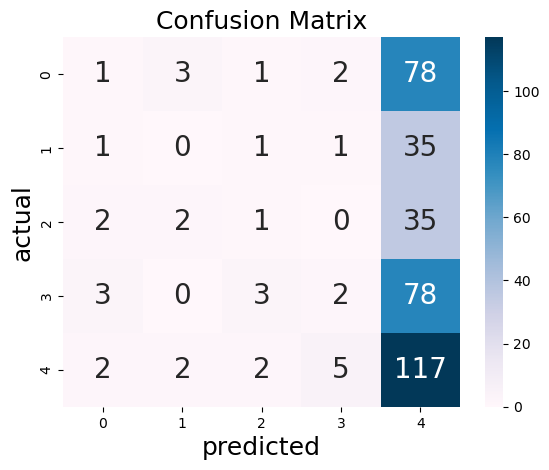

In [97]:
# evaluate performance metrics
evaluation(np.array(train_labels_misc_nonan), chatbot_predict_misc_numerical_nonan)

In [103]:
# calculate actual accuracy (including NaN responses as misclassifications)
print("Actual Accuracy: " + str(sum(np.array(train_labels_misc_nonan) == chatbot_predict_misc_numerical_nonan)/(len(chatbot_predict_misc_numerical_nonan) + np.count_nonzero(np.isnan(chatbot_predict_misc_numerical)))))

Actual Accuracy: 0.242


##### (b) Devinci engine

In [129]:
# loop through records and request API responses
openai.api_key = "..."
chatbot_predict_misc_davinci = []
model_engine="text-davinci-003"
for record in sample_idx3: 
    prompt = "Is the diagnosis a digestive system diseases, cardiovascular diseases, neoplasms, nervous system diseases, \
    or general pathological conditions if the patient has the following conditions: '" + str(train_text_misc[record]) + "'"
    
    completion = openai.Completion.create(
        engine = model_engine,
        prompt = prompt,
        max_tokens=1024,
        n=1,
        stop=None,
        temperature=0.5)

    response = completion.choices[0].text
    chatbot_predict_misc_davinci.append(response)

In [130]:
# remove "\n" characters from text and split into list
temp = chatbot_predict_misc_davinci
temp = str(temp).lower()
temp = temp.replace('\\n\\n','')
temp = temp.split(',')

In [131]:
# convert API responses into categorical-numerical responses
n_samples = 500
chatbot_predict_misc_davinci_numerical = np.empty(n_samples)
for sample in range(len(chatbot_predict_misc)):
    substring1 = "digestive"
    substring3 = "cardiovascular"
    substring0 = "neoplasm"
    substring2 = "nervous"
    substring4 = "general pathological"

    if substring0 in temp[sample]:
        chatbot_predict_misc_davinci_numerical[sample] = 0
    elif substring1 in temp[sample]:
        chatbot_predict_misc_davinci_numerical[sample] = 1
    elif substring2 in temp[sample]:
        chatbot_predict_misc_davinci_numerical[sample] = 2
    elif substring3 in temp[sample]:
        chatbot_predict_misc_davinci_numerical[sample] = 3
    elif substring4 in temp[sample]:
        chatbot_predict_misc_davinci_numerical[sample] = 4
    else: # the case where the API did not predict any of the options, replace with NaN
        chatbot_predict_misc_davinci_numerical[sample] = np.nan

In [132]:
# count NaN values
np.count_nonzero(np.isnan(chatbot_predict_misc_davinci_numerical))

8

In [133]:
# remove NaN observations from the samples and labels
nan_idx = np.argwhere(np.isnan(chatbot_predict_misc_davinci_numerical))
chatbot_predict_misc_davinci_numerical_nonan = np.delete(chatbot_predict_misc_davinci_numerical, obj=nan_idx, axis=0)
train_labels_misc_davinci_nonan = np.delete(np.array(train_label_misc.iloc[sample_idx3]), obj=nan_idx, axis=0)

Recall:  0.31882702132343455
Accuracy:  0.3394308943089431
Precision:  0.3408065574756331
F1:  0.31757939997464907


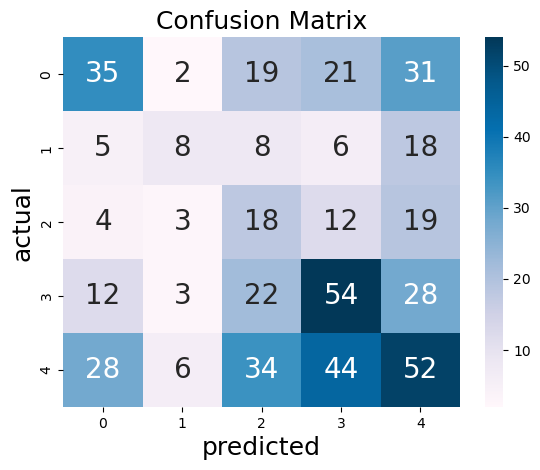

In [134]:
# evaluate performance metrics
evaluation(np.array(train_labels_misc_davinci_nonan), chatbot_predict_misc_davinci_numerical_nonan)

In [136]:
# calculate actual accuracy (including NaN responses as misclassifications)
print("Actual Accuracy: " + str(sum(np.array(train_labels_misc_davinci_nonan) == chatbot_predict_misc_davinci_numerical_nonan)/(len(chatbot_predict_misc_davinci_numerical_nonan) + np.count_nonzero(np.isnan(chatbot_predict_misc_davinci_numerical)))))

Actual Accuracy: 0.334
